# Анализ растров [norm.]diff1516.N 

In [1]:
import numpy as np

import utilites

from utilites import (
    get_grassdata_path,
    get_location_name,
    get_ll_location_name,
    get_location_path,
    get_gisbase_path
)

import grasslib
reload(grasslib)

from grasslib import GRASS

In [5]:
# inputs = ['diff1615.%d@basemaps'%i for i in range(1, 12)]
inputs = ['norm.diff1615.%d@basemaps'%i for i in range(1, 12)]
print inputs
output = 'tr1516.alrm@basemaps'

['norm.diff1615.1@basemaps', 'norm.diff1615.2@basemaps', 'norm.diff1615.3@basemaps', 'norm.diff1615.4@basemaps', 'norm.diff1615.5@basemaps', 'norm.diff1615.6@basemaps', 'norm.diff1615.7@basemaps', 'norm.diff1615.8@basemaps', 'norm.diff1615.9@basemaps', 'norm.diff1615.10@basemaps', 'norm.diff1615.11@basemaps']


In [3]:
grs = GRASS(gisbase=get_gisbase_path(), 
            dbase=get_grassdata_path(), 
            location=get_location_name(),
            mapset='alisovenko_common'
)

In [4]:
from sklearn.model_selection import train_test_split

X_data = grs.rasters_to_array(inputs)
Y_data = grs.rasters_to_array([output]).ravel()

In [20]:
print X_data.shape
print Y_data.shape

(9817500, 11)
(9817500,)
[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


In [15]:
# Сортируем так чтобы объекты-рубки оказались в конце списка, 
# чтобы на графиках их было видно - они будут отрисовываться после объектов-нерубок
Y_inds = Y_data.argsort()

X_data_sorted = X_data[Y_inds]
Y_data_sorted = Y_data[Y_inds]

In [39]:
from matplotlib.colors import ListedColormap

%pylab inline

colors = ListedColormap(['red', 'blue'])

# Аттрибутов у нас 11.
# i, j - инексы аттрибутов которое хотим отразить на графике
def print_plot(i, j):
    pylab.figure(figsize=(16,12))
    pylab.scatter(
        X_data_sorted[ : , i],
        X_data_sorted[ : , j],
        c = Y_data_sorted[ : ],
        cmap = colors)
    pylab.title('Attributes %d %d' % (i, j))
    pylab.xlabel('attr %d' % i)
    pylab.ylabel('attr %d' % j)
    plt.colorbar()
    pylab.show()

Populating the interactive namespace from numpy and matplotlib


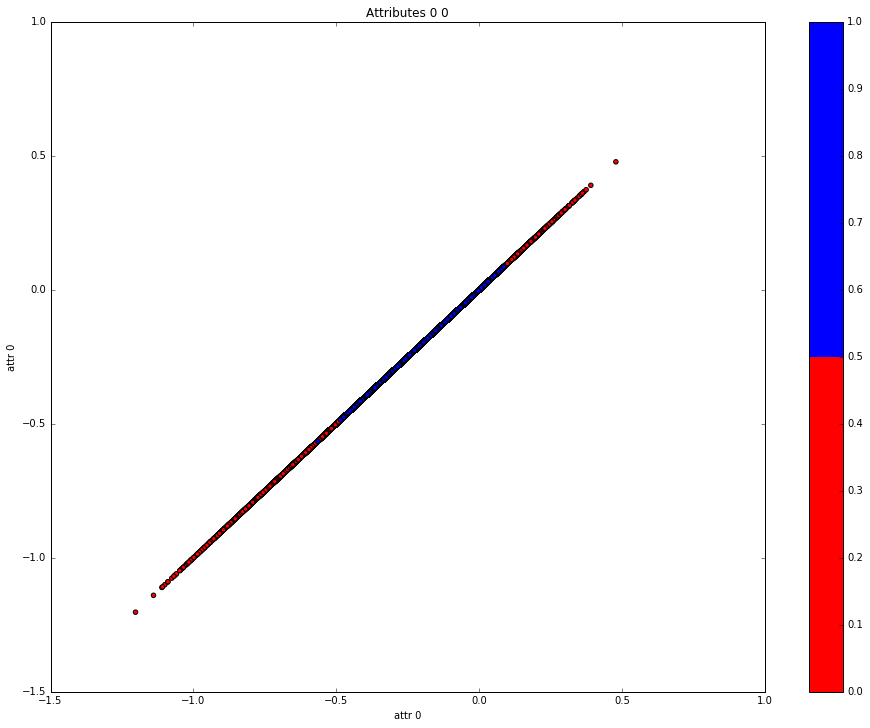

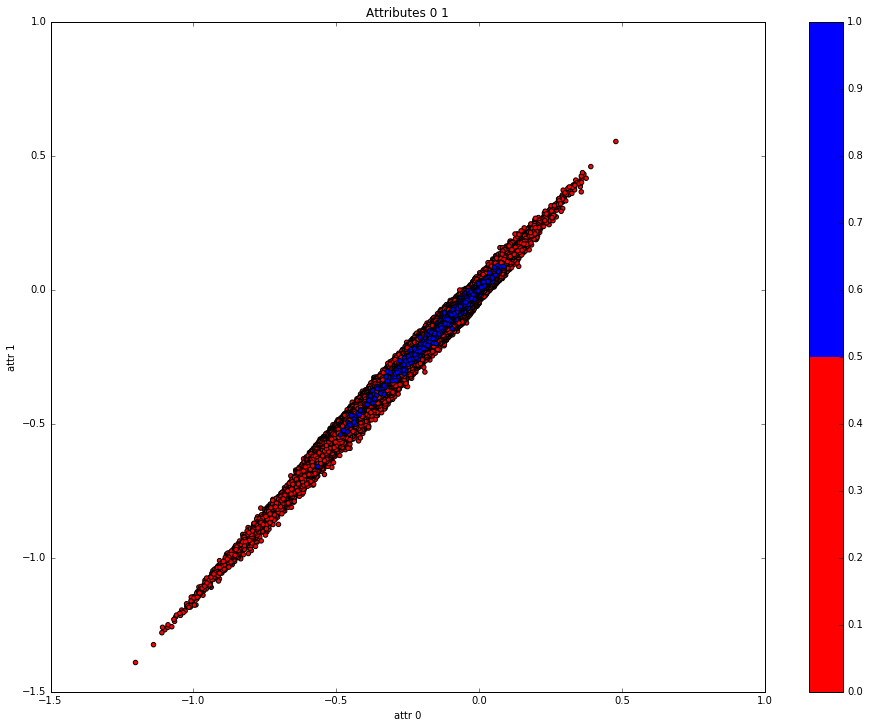

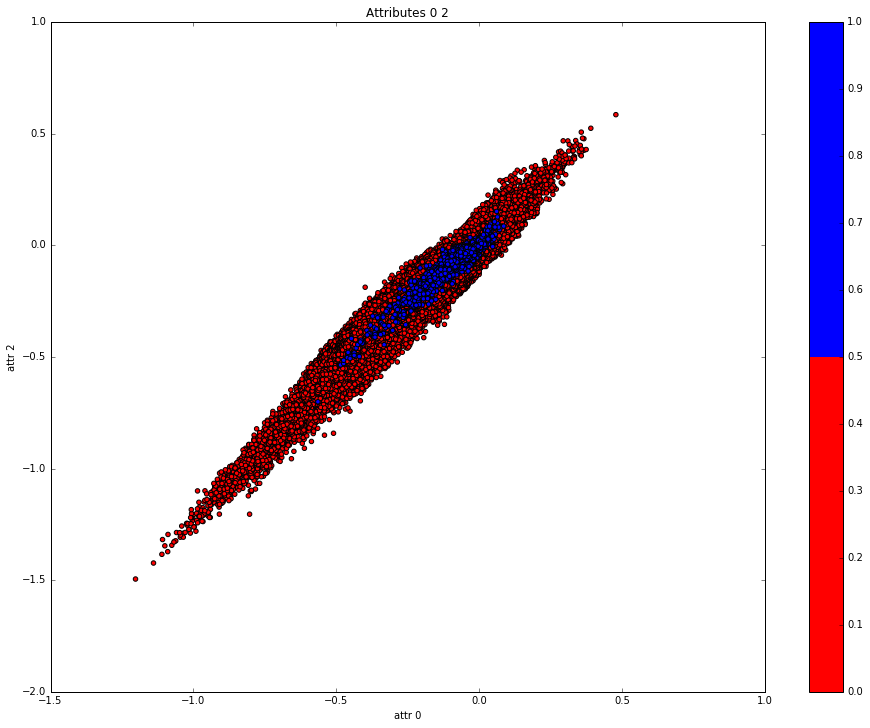

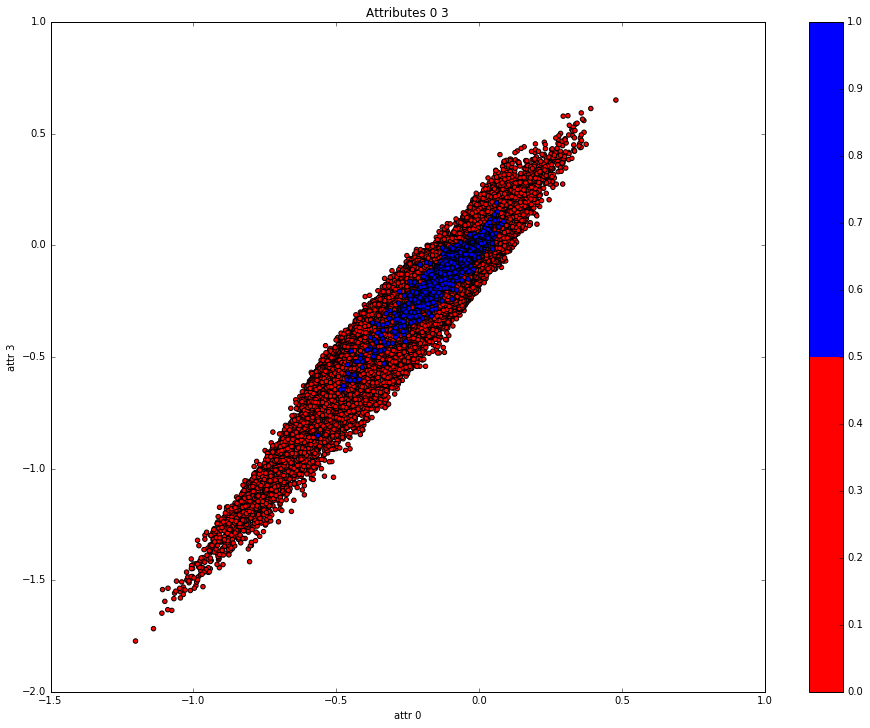

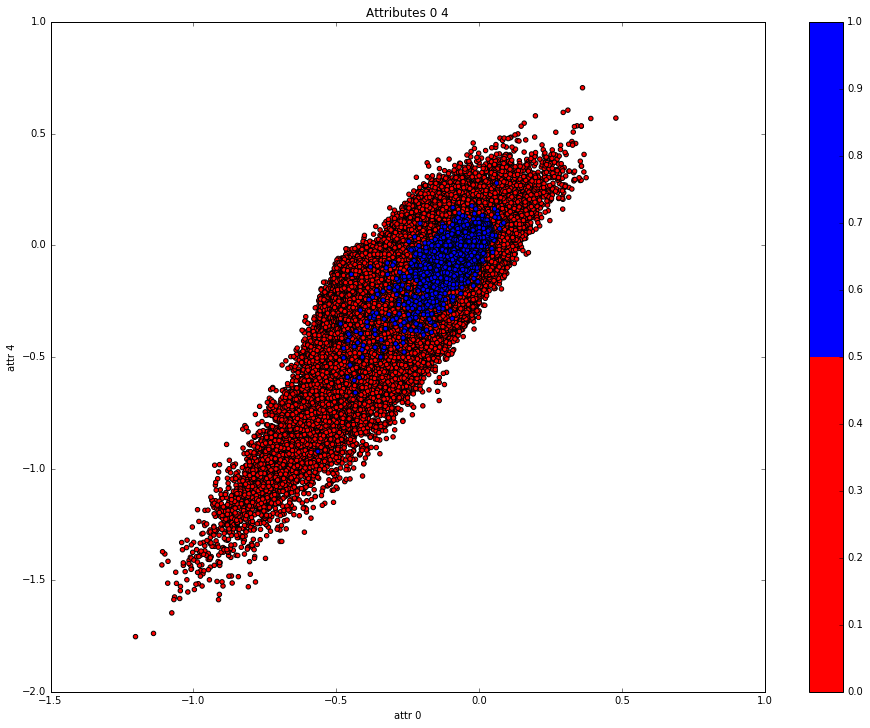

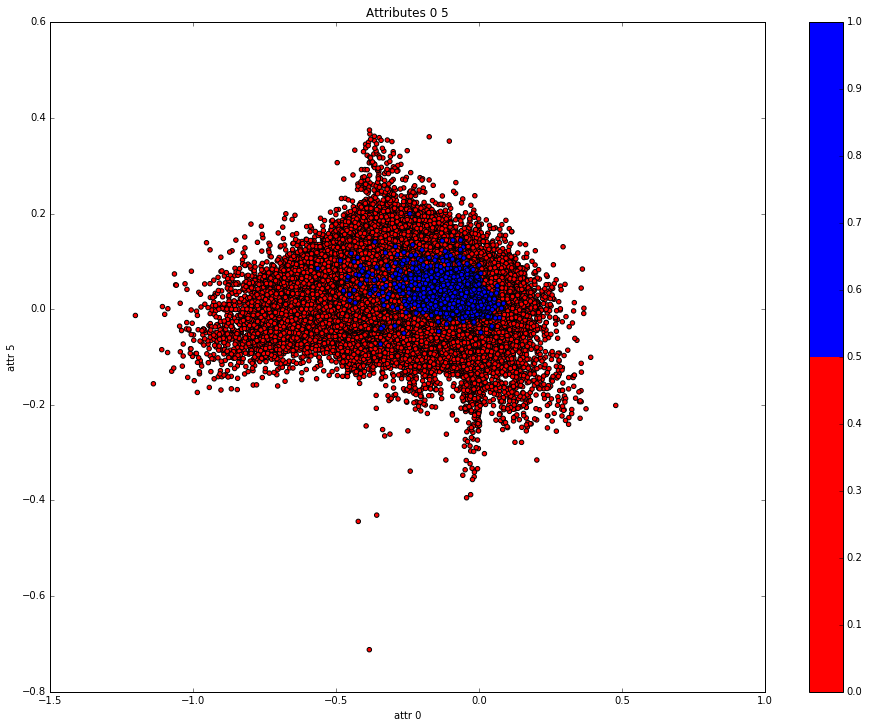

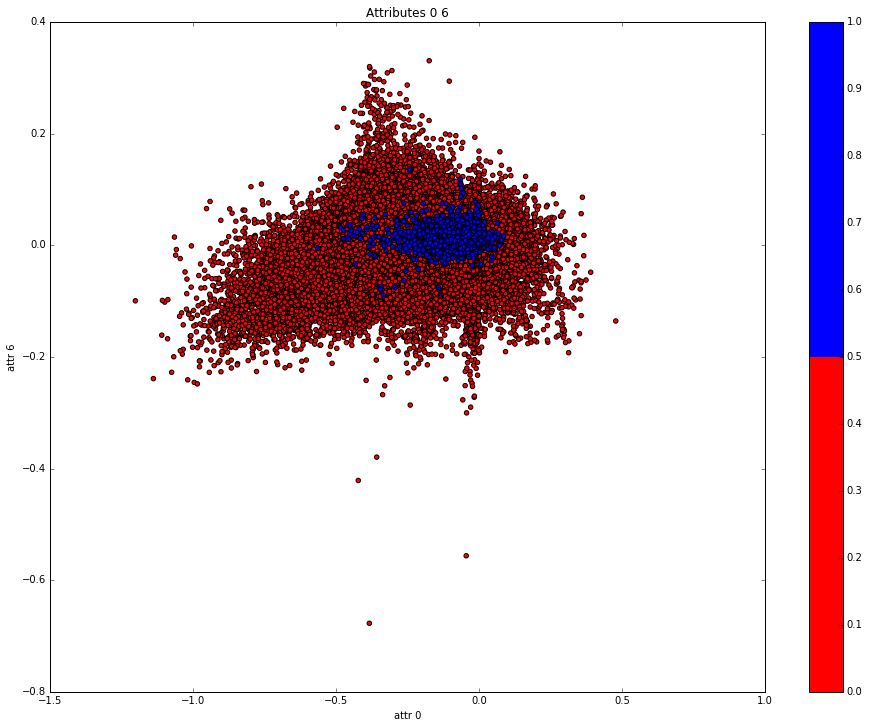

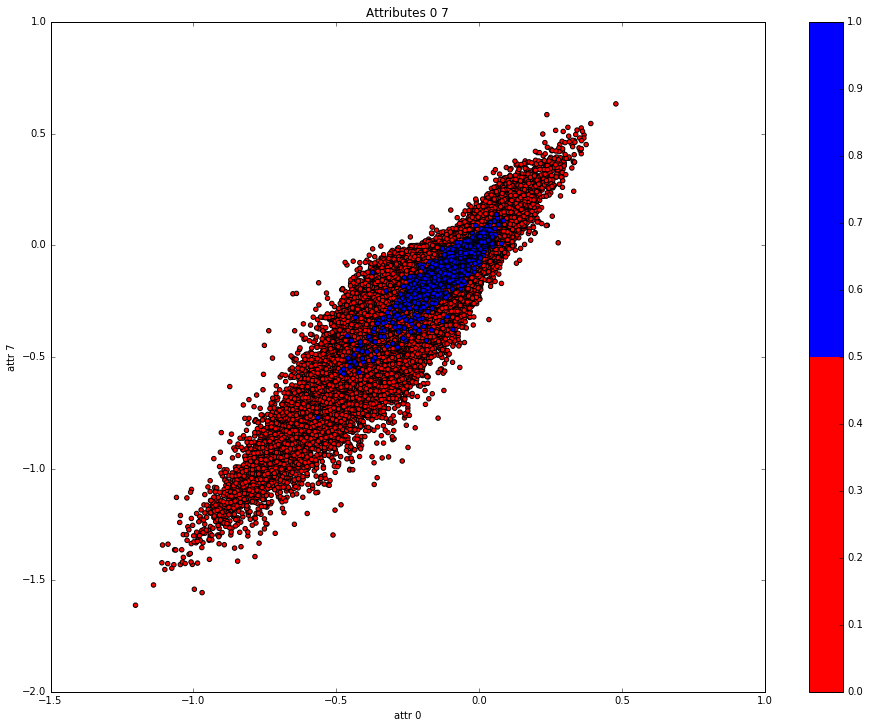

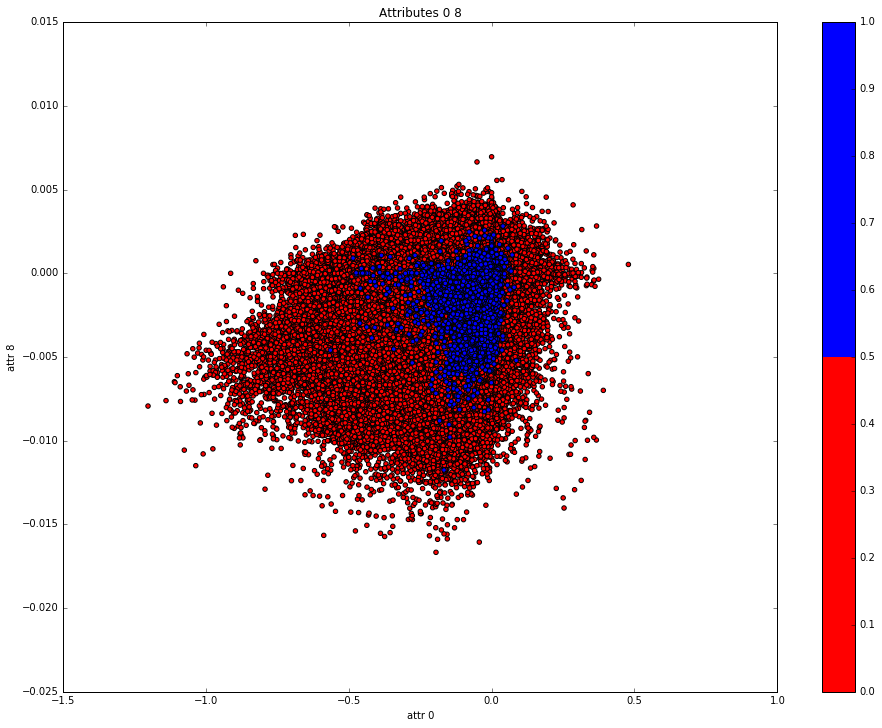

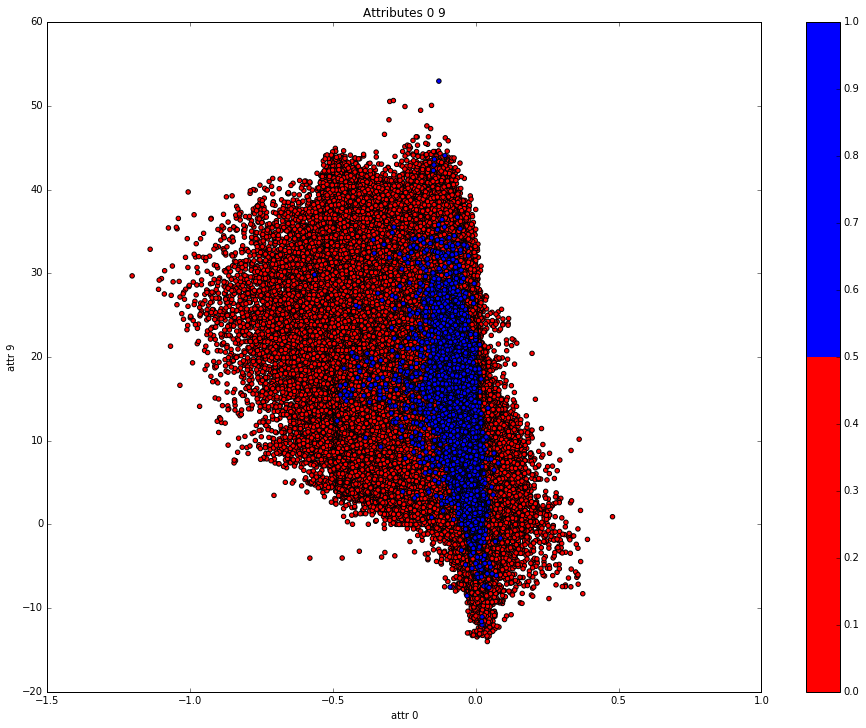

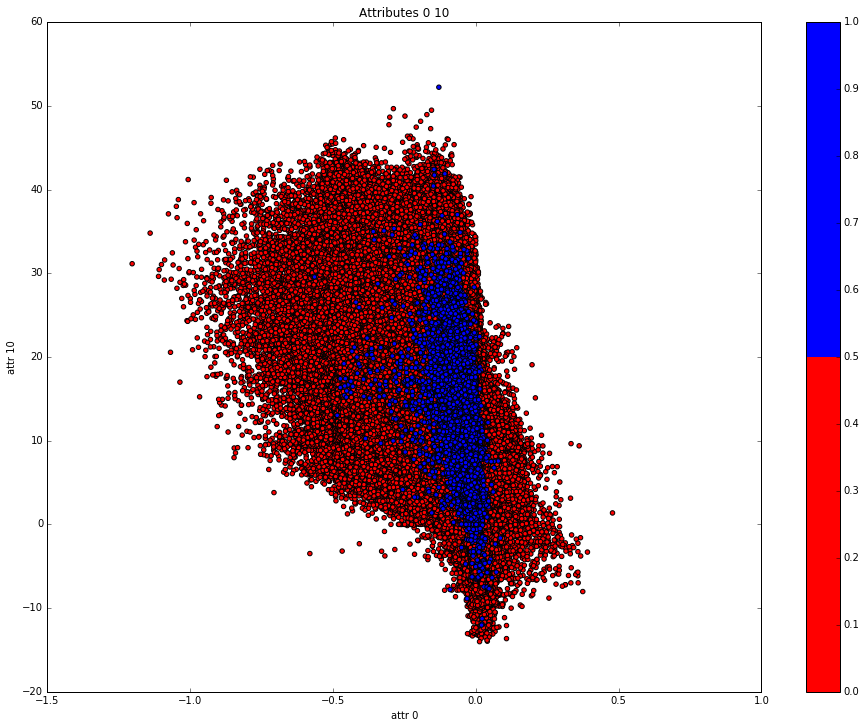

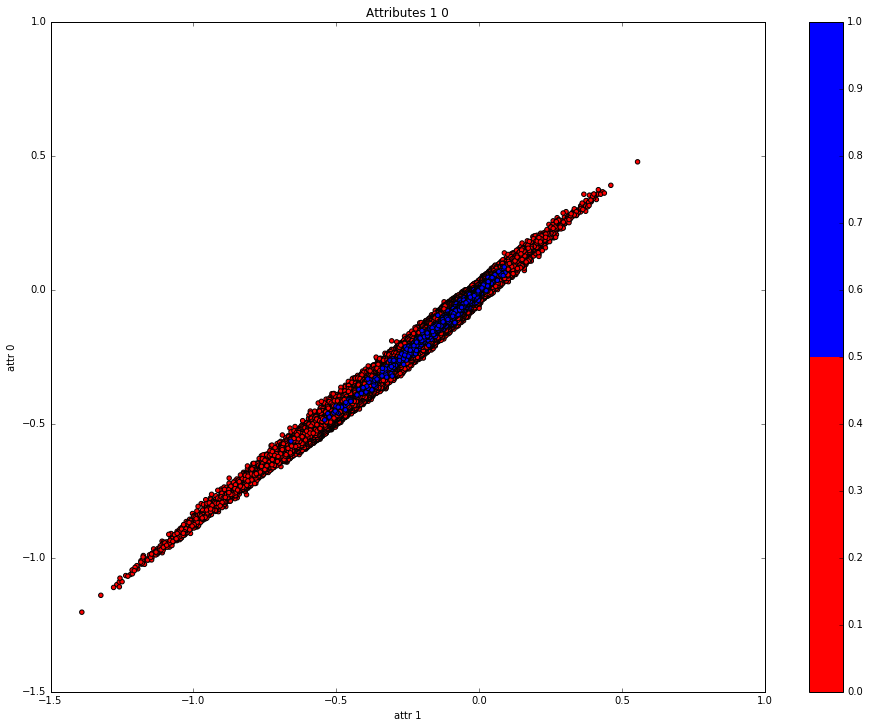

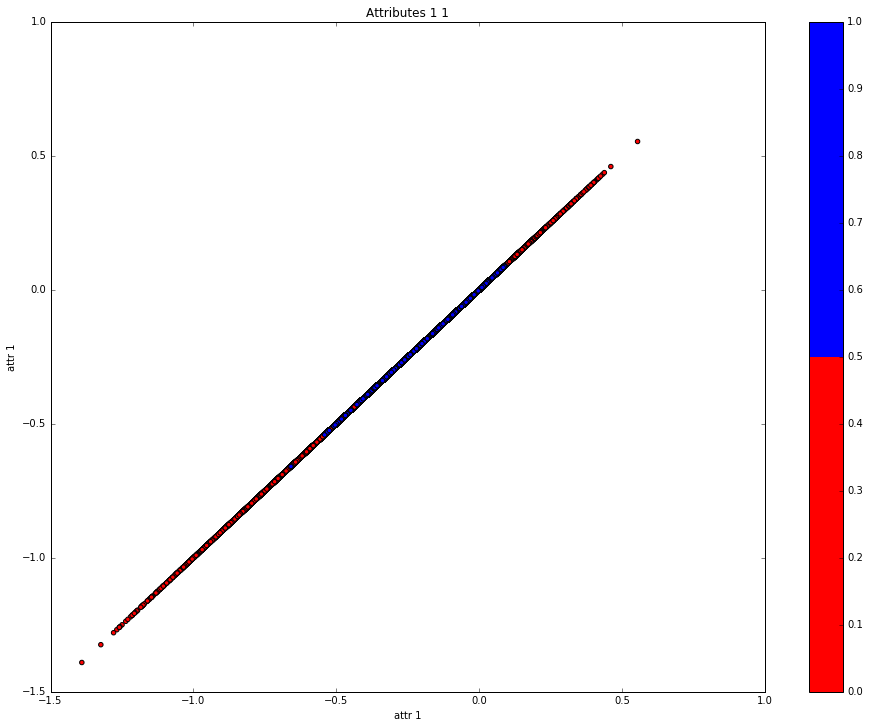

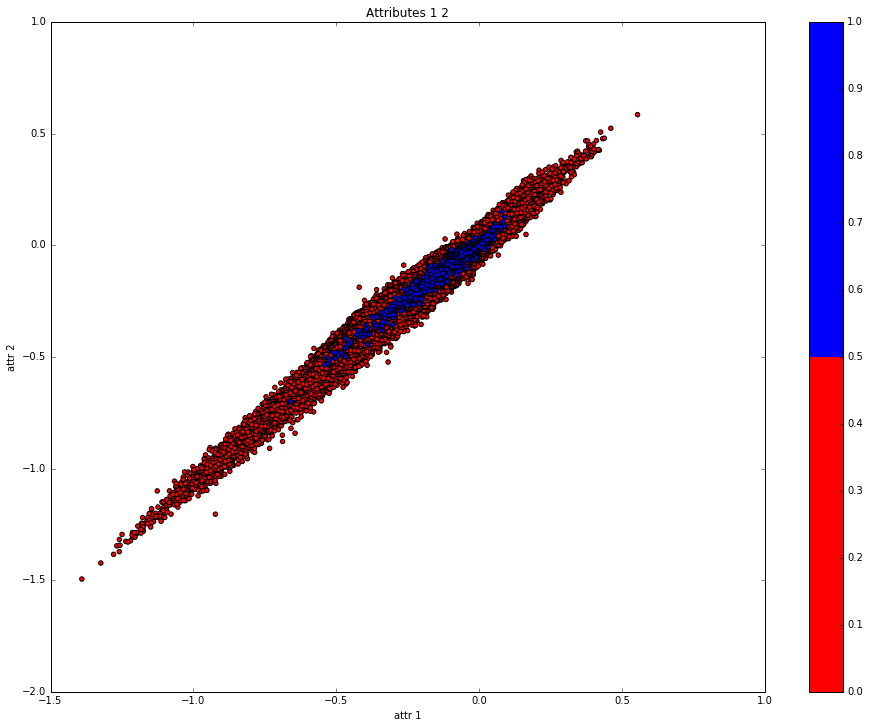

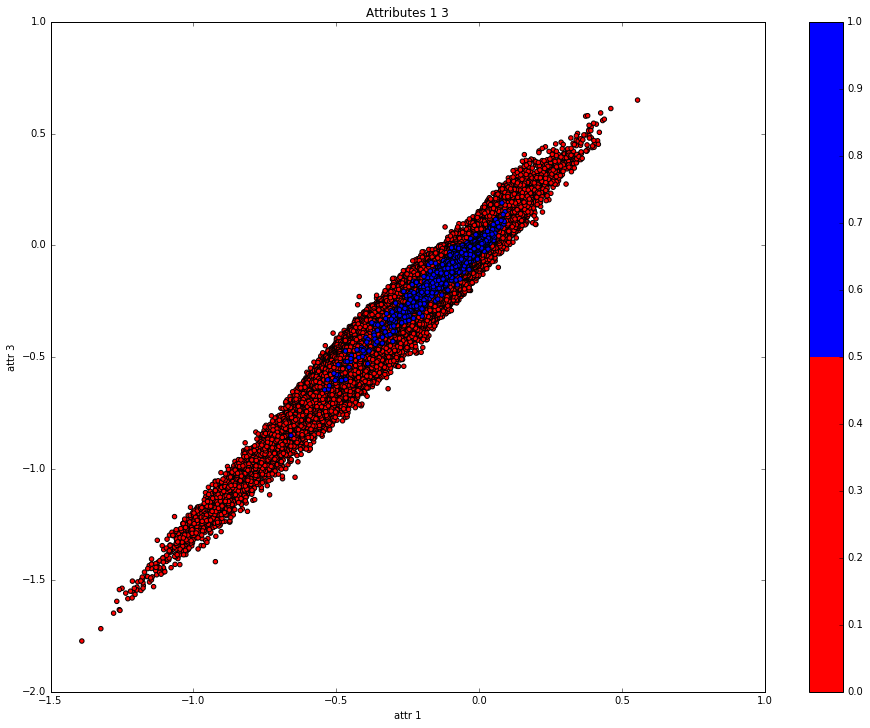

In [ ]:
for i in range(11):
    for j in range(11):
        print_plot(i, j)